In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('/content/DATASET.csv')
del df['Timestamp']
df.head()

,Memory usage [MB]
0,1026
1,1070
2,1001
3,969
4,1103


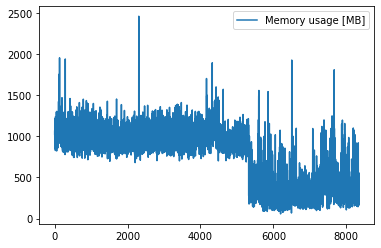

In [26]:
df.plot()
plt.show()


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
train = df.iloc[:4000]
test = df.iloc[4000:4011]

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.head(),df.tail()

(   Memory usage [MB]
 0               1026
 1               1070
 2               1001
 3                969
 4               1103,       Memory usage [MB]
 8347                163
 8348                483
 8349                242
 8350                382
 8351                234)

In [30]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train[:10]

array([[0.19471019],
       [0.21947102],
       [0.18064153],
       [0.16263365],
       [0.23804164],
       [0.21778278],
       [0.14406303],
       [0.27011818],
       [0.22228475],
       [0.2301632 ]])

In [31]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [33]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.19471019 0.21947102 0.18064153]
Predict this y: 
 [[0.16263365]]


In [34]:
X.shape

(1, 3, 1)

In [35]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [37]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(generator,epochs=5)

Epoch 1/5
3988/3988 [==============================] - 30s 7ms/step - loss: 0.0050
Epoch 2/5
3988/3988 [==============================] - 29s 7ms/step - loss: 0.0045
Epoch 3/5
3988/3988 [==============================] - 28s 7ms/step - loss: 0.0039
Epoch 4/5
3988/3988 [==============================] - 29s 7ms/step - loss: 0.0038
Epoch 5/5
3988/3988 [==============================] - 29s 7ms/step - loss: 0.0038


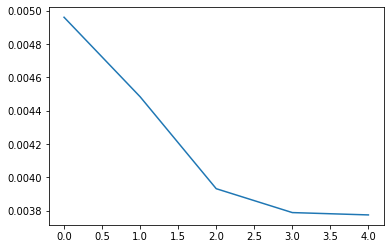

In [40]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [41]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

array([[0.14658509]], dtype=float32)

In [42]:
scaled_test[0]

array([0.14237479])

In [43]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


In [44]:
for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [45]:
test_predictions

[array([0.14658509], dtype=float32),
 array([0.15180811], dtype=float32),
 array([0.1589526], dtype=float32),
 array([0.27838266], dtype=float32),
 array([0.20268363], dtype=float32),
 array([0.16956879], dtype=float32),
 array([0.16026407], dtype=float32),
 array([0.16679263], dtype=float32),
 array([0.17756253], dtype=float32),
 array([0.16523722], dtype=float32),
 array([0.15500924], dtype=float32)]

In [46]:
test.head()

,Memory usage [MB]
4000,933
4001,1100
4002,1010
4003,1168
4004,991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


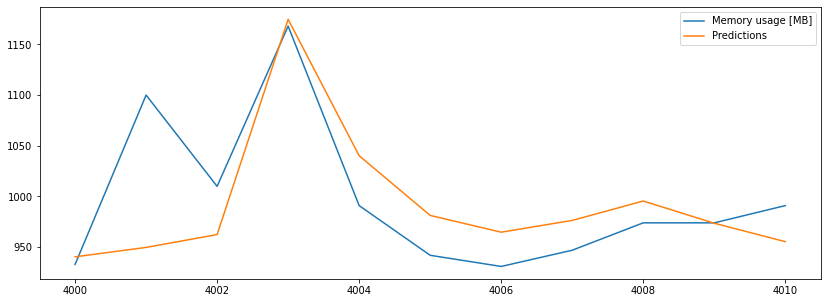

In [47]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5))

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Memory usage [MB]'],test['Predictions']))
print(rmse)

54.46330385036275
